# PCA Comparaison on different platforms

In this notebook, ....


### General Informations

In [ ]:
!pip install pycuda
!apt-get install -y --no-install-recommends libcudart-dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.8 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2022.2.2-cp310-cp310-linux_x86_64.whl size=661975 sha256=bd6c5a1620165b3ca145190d4452266d091475fb5bcc06ffd5e169f35d2c8c4f
  Stored in directory: /root/.cache/pip/wheels/1d/7b/06/82a395a243fce00035dea9914d92bbef0013401497d849f8bc
  Created wheel for pytools: filename=pytools-2022.1.14-py2.py3-none-any.whl size=69855 sha256=442057d2f67d5defd3a3a9951e883af093b6341c952aa8efa53f1cafd3f5d9f6
  Stored in directory: /root/.cache/pip/wheels/19/0

In [ ]:
import platform
import multiprocessing
import pycuda.driver as cuda

In [ ]:
# Print CPU type
cpu_type = platform.processor()
print("CPU Type:", cpu_type)

# Print the number of CPU cores
num_cores = multiprocessing.cpu_count()
print("Number of CPU Cores:", num_cores)

print('*********************')
# Initialize CUDA
cuda.init()

# Get the number of available GPUs
num_gpus = cuda.Device.count()
print("Number of GPUs:", num_gpus)

# Iterate over each GPU and print its properties
for i in range(num_gpus):
    gpu_device = cuda.Device(i)
    print("GPU", i)
    print("  Name:", gpu_device.name())
    print("  Total Memory:", gpu_device.total_memory() // (1024**2), "MB")
    print("  Compute Capability:", ".".join(str(x) for x in gpu_device.compute_capability()))

CPU Type: x86_64
Number of CPU Cores: 12
*********************
Number of GPUs: 1
GPU 0
  Name: NVIDIA A100-SXM4-40GB
  Total Memory: 40513 MB
  Compute Capability: 8.0


### Import Libraries

In [ ]:
import numpy as np 
import cupy as cp

In [ ]:
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

## Function for Data simulation

In [ ]:
def simulate_data(n_rows, n_cols, mean, std, scale):
    # Generate a random dataset with n_rows rows and n_cols columns
    cov_mat = np.diag(np.random.rand(n_cols) * std) # Generate a covariance matrix with different variances along each feature
    data = np.random.multivariate_normal(mean=np.zeros(n_cols), cov=cov_mat, size=n_rows)
    data = data * scale + mean
    
    # Subtract the mean from each column to normalize the data
    data = data - np.mean(data, axis=0)
    
    # Convert the NumPy array to a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df

### PCA Steps on cupy and numpy

* Sorting eigenvectors

In [ ]:
def sort_eigenvectors(eig_values, eig_vectors):
    """
    Sorts eigenvectors and eigenvalues in descending order by eigenvalues.
    Returns sorted eigenvectors and eigenvalues.
    """
    if isinstance(eig_values, np.ndarray) and isinstance(eig_vectors, np.ndarray):
        # NumPy on CPU
        e_indices = np.argsort(eig_values)[::-1]
        eigenvectors_sorted = eig_vectors[:, e_indices]
        eigenvalues_sorted = eig_values[e_indices]
    elif isinstance(eig_values, cp.ndarray) and isinstance(eig_vectors, cp.ndarray):
        # CuPy on GPU
        e_indices = cp.argsort(eig_values)[::-1]
        eigenvectors_sorted = eig_vectors[:, e_indices]
        eigenvalues_sorted = eig_values[e_indices]
    else:
        raise ValueError("invalid input types,")

    return eigenvalues_sorted, eigenvectors_sorted

* Computing variance

In [ ]:
def calculate_variance_explained(eigenvalues):
    """
    Computes the percentage of explained variance for each eigenvalue in the input list
    """
    if isinstance(eigenvalues, np.ndarray):
        # NumPy on CPU
        total_variance = np.sum(eigenvalues)
        variance_explained = (eigenvalues / total_variance) * 100
    elif isinstance(eigenvalues, cp.ndarray):
        # CuPy on GPU
        total_variance = cp.sum(eigenvalues)
        variance_explained = (eigenvalues / total_variance) * 100
    else:
        raise ValueError("Invalid input type.")

    return variance_explained

* Comparaison

In [ ]:
# numpy on CPU
def compute_principal_components_np(variance_explained, threshold):
    

    variance_cumulative = np.cumsum(variance_explained)
    variance_percentage = variance_explained / np.sum(variance_explained) * 100

    index = np.argmax(variance_cumulative >= threshold)
  

    return index + 1

# cupy on GPU
def compute_principal_components_cp(variance_explained, threshold):
    

    variance_explained_cp = cp.asarray(variance_explained)
    variance_cumulative = cp.cumsum(variance_explained_cp)
    variance_percentage = variance_explained_cp / cp.sum(variance_explained_cp) * 100

    index = cp.argmax(variance_cumulative >= threshold)

    #transfer the result back to the CPU
    index = cp.asnumpy(index)

    

    return index + 1

* PCA Execution

In [ ]:
def naivePCA(data, threshold):
    """
    Perform PCA on a simulated dataset and return the number of principal components that explain at least the specified threshold
    of the variance.

    Inputs:
    - data (pandas.DataFrame): input dataset for PCA
    - threshold (float): the minimum percentage of variance explained by the principal components to be returned

    Outputs:
    - cov_time (float): execution time for computing the covariance matrix
    - eig_time (float): execution time for calculating eigenvectors and eigenvalues
    - sort_time (float): execution time for sorting eigenvectors and eigenvalues
    - var_time (float): execution time for calculating variance explained
    - pc_time (float): execution time for calculating the minimum number of principal components
    - proj_time (float): execution time for reprojecting the data
    - total_time (float): the total execution time in seconds of the PCA algorithm
    - principal_components_num (int): the number of principal components that explain at least the specified threshold of the variance
    """

    start_time = time.time()

    # Computing the covariance matrix
    cov_mat_start = time.time()
    cov_mat = data.cov()
    cov_mat_end = time.time()
    cov_time = cov_mat_end - cov_mat_start

    # Calculating the eigenvectors and eigenvalues
    eig_start = time.time()
    eig_values, eig_vectors = np.linalg.eig(cov_mat)
    eig_end = time.time()
    eig_time = eig_end - eig_start

    # Sort the eigenvectors and eigenvalues
    sort_start = time.time()
    eigenvalues_sorted, eigenvectors_sorted = sort_eigenvectors(eig_values, eig_vectors)
    sort_end = time.time()
    sort_time = sort_end - sort_start

    # Explained Variance
    variance_start = time.time()
    variance_explained = calculate_variance_explained(eigenvalues_sorted)
    variance_end = time.time()
    var_time = variance_end - variance_start

    # Calculate the minimum number of principal components for which the variance explained is greater than or equal to threshold
    pc_start = time.time()
    principal_components_num = compute_principal_components_np(variance_explained, threshold)
    pc_end = time.time()
    pc_time = pc_end - pc_start

    # Reprojecting the data
    proj_start = time.time()
    reprojected_data = np.dot(data, eigenvectors_sorted[:, :principal_components_num])
    proj_end = time.time()
    proj_time = proj_end - proj_start

    end_time = time.time()
    total_time = end_time - start_time

    return cov_time, eig_time, sort_time, var_time, pc_time, proj_time, total_time, principal_components_num

In [ ]:
import time
import cupy as cp

def cupy_naivePCA(data, threshold):
    start_time = time.time()

    # Computing the covariance matrix
    cov_mat_start = time.time()
    cov_mat_gpu = cp.cov(data, rowvar=False)
    cov_mat_end = time.time()
    cov_time = cov_mat_end - cov_mat_start

    # Calculating the eigenvectors and eigenvalues
    eig_start = time.time()
    eig_values_gpu, eig_vectors_gpu = cp.linalg.eigh(cov_mat_gpu)
    eig_end = time.time()
    eig_time = eig_end - eig_start

    # Sort the eigenvectors and eigenvalues
    sort_start = time.time()
    eigenvalues_sorted_gpu, eigenvectors_sorted_gpu = sort_eigenvectors(eig_values_gpu, eig_vectors_gpu)
    sort_end = time.time()
    sort_time = sort_end - sort_start

    # Explained Variance 
    variance_start = time.time()
    variance_explained_gpu = calculate_variance_explained(eigenvalues_sorted_gpu)
    variance_end = time.time()
    var_time = variance_end - variance_start

    # Calculate the minimum number of principal components for which the variance explained is greater than or equal to threshold
    pc_start = time.time()
    principal_components_num_gpu = compute_principal_components_cp(variance_explained_gpu, threshold)
    pc_end = time.time()
    pc_time = pc_end - pc_start

    # Reprojecting the data
    proj_start = time.time()
    reprojected_data_gpu = cp.dot(data, eigenvectors_sorted_gpu[:, :principal_components_num_gpu])
    proj_end = time.time()
    proj_time = proj_end - proj_start

    end_time = time.time()
    total_time = end_time - start_time

    return cov_time, eig_time, sort_time, var_time, pc_time, proj_time, total_time, principal_components_num_gpu

# Rest of the code remains the same


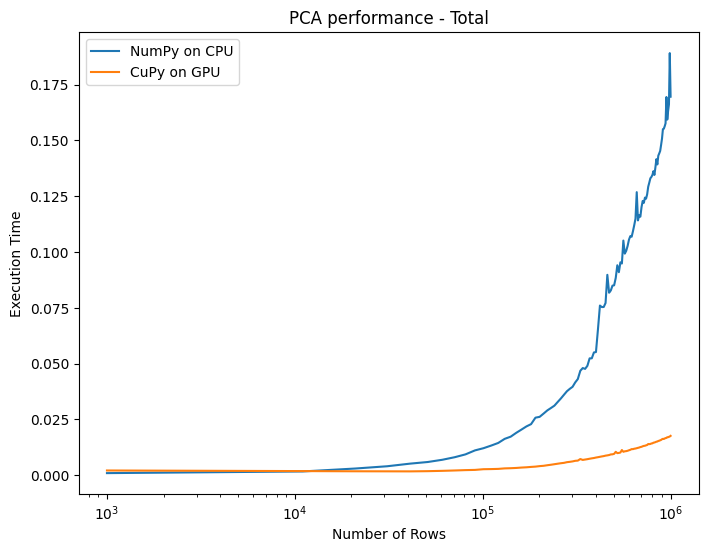

In [ ]:
# Define the parameters for the simulation
cols = 10
mean = 0  
std = 100
scale = 100
threshold = 50

# Define the number of rows and the step size
min_rows = 1000
step_size = 10000
iterations = 100
max_rows = min_rows + step_size * iterations

data = simulate_data(max_rows, cols, mean, std, scale)


# Define the row numbers as a grid from 10 to max_rows in steps of step_size
row_numbers = np.arange(min_rows, max_rows + 1, step_size)

# Initialize empty lists to store the execution times and number of principal components
cov_times, cupy_cov_times = [], []
eig_times, cupy_eig_times = [], []
sort_times, cupy_sort_times = [], []
var_times, cupy_var_times = [], []
pc_times, cupy_pc_times = [], []
proj_times, cupy_proj_times = [], []
total_times, cupy_total_times = [], []

# Call the naivePCA function for each row number and store the results in the lists
for rows in row_numbers:
  
    random_data = pd.DataFrame(data[:rows])
    
    # Call the NumPy version of the function
    cov_time, eig_time, sort_time, var_time, pc_time, proj_time, total_time, num_pc = naivePCA(random_data, threshold)

    cov_times.append(cov_time)
    eig_times.append(eig_time)
    sort_times.append(sort_time)
    var_times.append(var_time)
    pc_times.append(pc_time)
    proj_times.append(proj_time)
    total_times.append(total_time)
    
    # Call the CuPy version of the function
    cupy_cov_time, cupy_eig_time, cupy_sort_time, cupy_var_time, cupy_pc_time, cupy_proj_time, cupy_total_time, cupy_num_pc = cupy_naivePCA(cp.array(random_data), threshold)
    
    cupy_cov_times.append(cupy_cov_time)
    cupy_eig_times.append(cupy_eig_time)
    cupy_sort_times.append(cupy_sort_time)
    cupy_var_times.append(cupy_var_time)
    cupy_pc_times.append(cupy_pc_time)
    cupy_proj_times.append(cupy_proj_time)
    cupy_total_times.append(cupy_total_time)
    
#Total Execution Time
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(row_numbers, total_times, label="NumPy on CPU")
ax.plot(row_numbers, cupy_total_times, label="CuPy on GPU")
ax.set_xscale('log')
ax.set_xlabel('Number of Rows')
ax.set_ylabel('Execution Time')
ax.set_title('PCA performance - Total')
ax.legend()

# Show the plots
plt.show()


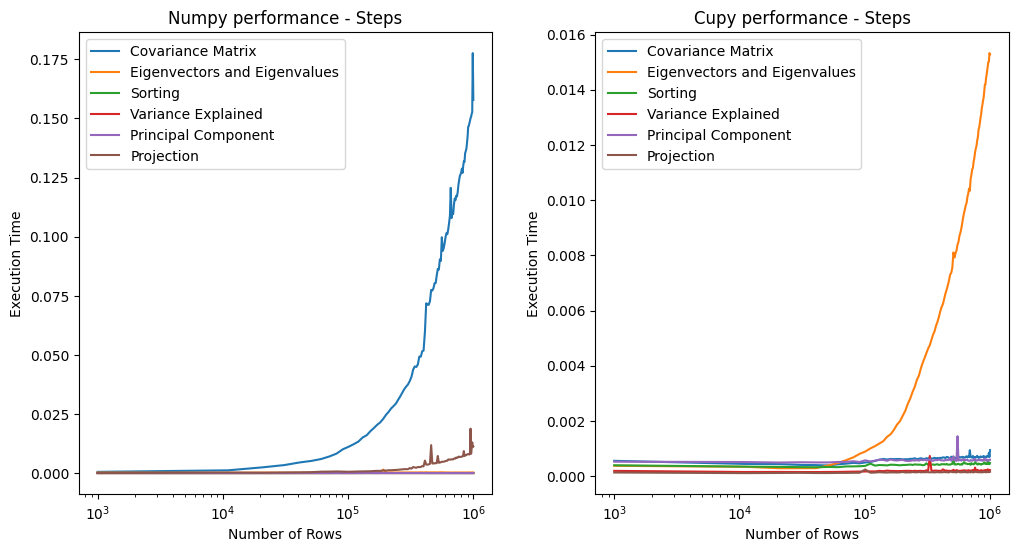

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Figure 1: Individual Execution Time fo Numpy PCA
ax1.plot(row_numbers, cov_times, label="Covariance Matrix")
ax1.plot(row_numbers, eig_times, label="Eigenvectors and Eigenvalues")
ax1.plot(row_numbers, sort_times, label="Sorting")
ax1.plot(row_numbers, var_times, label="Variance Explained")
ax1.plot(row_numbers, pc_times, label="Principal Component")
ax1.plot(row_numbers, proj_times, label="Projection")
ax1.set_xscale('log')
ax1.set_xlabel('Number of Rows')
ax1.set_ylabel('Execution Time')
ax1.set_title('Numpy performance - Steps')
ax1.legend()

# Figure 2: Individual Execution Times for Cupy PCA
ax2.plot(row_numbers, cupy_cov_times, label="Covariance Matrix")
ax2.plot(row_numbers, cupy_eig_times, label="Eigenvectors and Eigenvalues")
ax2.plot(row_numbers, cupy_sort_times, label="Sorting")
ax2.plot(row_numbers, cupy_var_times, label="Variance Explained")
ax2.plot(row_numbers, cupy_pc_times, label="Principal Component")
ax2.plot(row_numbers, cupy_proj_times, label="Projection")
ax2.set_xscale('log')
ax2.set_xlabel('Number of Rows')
ax2.set_ylabel('Execution Time')
ax2.set_title('Cupy performance - Steps')
ax2.legend()

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.25)

# Show the plots
plt.show()

Figure 1 clearly demonstrates the significant advantage of using CuPy for performing PCA computations. As expected, the execution time of the CuPy implementation is considerably faster compared to the Numpy CPU-based implementation. This notable difference in performance can be attributed to the inherent parallelization capabilities of GPUs.

One interesting observation from Figure 2 is that computing the covariance matrix of the data does not have a substantial impact on the execution time in the case of the CuPy implementation, unlike the NumPy implementation. However, it is worth noting that computing eigenvectors and eigenvalues becomes the most time-consuming operation starting from 100,000 rows. The computation of eigenvectors and eigenvalues is performed using the cp.linalg.eigh function in CuPy, which is the CuPy equivalent of NumPy's numpy.linalg.eigh function. Although CuPy utilizes GPU acceleration for these calculations, the inherent complexity of eigenvalue computations can still result in longer execution times compared to computing the covariance matrix.

## End